In [1]:
from gym import Env 
from gym import spaces 
from IPython.display import clear_output
import random 
import numpy as np 
import random
import pprint
import matplotlib.pyplot as plt

In [2]:
# global constants

# game board values
NOTHING = 0
PLAYER = 1
# states
CHANGE = 2
NO_CHANGE= 3
# action values
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
# STAY = 4

NUM_ACTIONS = 4

# game board size
BOARD_SIZE = 6


In [3]:
def generate_user_profile(num_env_states, base_change_probability_range, lambda_fatigue_range, num_actions=4):
    user_profile = []
    user_lambda_fatigue = np.random.uniform(*lambda_fatigue_range)
    
    for _ in range(num_env_states):
        state_probabilities = []
        for _ in range(num_actions):
            base_change_probability_state = np.random.uniform(*base_change_probability_range)
            state_probabilities.append(base_change_probability_state)
        user_profile.append(state_probabilities)
    
    return user_profile, user_lambda_fatigue

def generate_all_users_profile(num_users, base_change_probability_range, lambda_fatigue_range):
    all_users_profiles = []
    all_users_lambda_fatigue = []
    
    for _ in range(num_users):
        user_profile, user_lambda_fatigue = generate_user_profile(36, base_change_probability_range, lambda_fatigue_range)
        all_users_profiles.append(user_profile)
        all_users_lambda_fatigue.append(user_lambda_fatigue)
    
    return all_users_profiles, all_users_lambda_fatigue
    
class User():
    def __init__(self, user_profile, lambda_fatigue):
        self._user_profile = user_profile
        self._lambda_fatigue = lambda_fatigue
        self._step_count = 0
    
    def change_state(self, state, action, previous_action):
        fatigue = 1 - np.exp(-self._lambda_fatigue * self._step_count)
        adjusted_change_probability = self._user_profile[state][action] * (1 - fatigue)
        self._step_count += 1
        # print(f"adjusted_change_probability: {adjusted_change_probability}")
        if np.random.uniform(0, 1) <= adjusted_change_probability:
            # print("CHANGE")
            return CHANGE
        else:
            return NO_CHANGE


In [4]:
class ExperimentEnv(Env):
    def __init__(self, user, max_iter=200):
        # custom class variable used to display the reward earned
        self.cumulative_reward = 0
        self.iter_number = 0
        self.max_iter = max_iter
        #
        # set the initial state to a flattened 6x6 grid with a randomly
        # placed player
        #
        self.state = [NOTHING] * 36
        self.player_position = random.randrange(0, 36)
        self.player_state = NO_CHANGE
        self.user = user
        
        self.state[self.player_position] = PLAYER
        # convert the python array into a numpy array 
        # (This is needed since Gym expects the state to be this way)
        self.state = np.array(self.state, dtype=np.int16)
        # observation space (valid ranges for observations in the state)
        self.observation_space = spaces.Box(0, 3, [36,], dtype=np.int16)
        # valid actions:
        #   0 = up
        #   1 = down
        #   2 = left
        #   3 = right
        #   4 = stay
        # spaces.Discrete(5) is a shortcut for defining the actions 0-4
        self.action_space = spaces.Discrete(5)

    def is_valid_action(self, action):
        if action == UP:
            return (self.player_position - 6) >= 0
        elif action == DOWN:
            return (self.player_position + 6) < 36
        elif action == LEFT:
            return (self.player_position % 6) != 0
        elif action == RIGHT:
            return (self.player_position % 6) != 5
        # elif action == STAY:
        #     return True
        return False
    
    def step(self, action):
        # placeholder for debugging information
        info = {}
        # set default values for done, reward, and the player position
        # before taking the action
        done = False
        reward = 0

        if self.iter_number >= self.max_iter:
            done = True
            return self.state, reward, done, info, True

        previous_position = self.player_position

        # take the action by moving the player
        if self.is_valid_action(action):
            if action == UP:
                self.player_position -= 6
            elif action == DOWN:
                self.player_position += 6
            elif action == LEFT:
                self.player_position -= 1
            elif action == RIGHT:
                self.player_position += 1
            self.iter_number += 1
        else:
            return self.state, reward, done, info, False

        # give the state of player
        self.player_state = self.user.change_state(previous_position, action, self.player_state)
        # print(f"Player State: {self.player_state}")

        # set reward based on the player's state
        if self.player_state == CHANGE:
            reward = 1.0
        elif self.player_state == NO_CHANGE:
            reward = -1.0
        else:
            reward = 0.0  # Default reward for other cases

        # Update the environment state
        if not done:
            # update the player position
            self.state[previous_position] = NOTHING
            self.state[self.player_position] = PLAYER

        self.cumulative_reward += reward
        # print(f"Action: {action}, Player Position: {self.player_position}, Reward: {reward}, Cumulative Reward: {self.cumulative_reward}")
        if not(self.state.any() == 1):
            print("###############")

        return self.state, reward, done, info, True
    
    def reset(self):
        self.cumulative_reward = 0
        self.iter_number = 0
        #
        # set the initial state to a flattened 6x6 grid with a randomly 
        # placed player
        #
        self.state = [NOTHING] * 36
        self.player_position = random.randrange(0, 36)
        
        self.state[self.player_position] = PLAYER
        # convert the python array into a numpy array 
        # (needed since Gym expects the state to be this way)
        self.state = np.array(self.state, dtype=np.int16)
        print(f"Environment reset. Player Position: {self.player_position}")
        pp = pprint.PrettyPrinter(indent=4)
        reshaped_state = self.state.reshape(6, 6)
        pp.pprint(reshaped_state)
        return self.state
    
    def render(self):
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint({"state": self.state.reshape(6, 6), "cumulative_reward": self.cumulative_reward})


In [5]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.99):
        self.env = env
        self.q_table = np.zeros((36, env.action_space.n))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay

    def choose_action(self, state):
        while True:
            if random.uniform(0, 1) < self.exploration_rate:
                action = self.env.action_space.sample()  # Explore action space
            else:
                action = np.argmax(self.q_table[state])  # Exploit learned values
            
            if self.env.is_valid_action(action):
                return action

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state, action]
        target = reward + self.discount_factor * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (target - predict)

    def update_exploration_rate(self):
        self.exploration_rate *= self.exploration_decay


In [6]:
# Initialize lists to collect metrics for all users
all_cumulative_rewards = []
all_average_rewards = []
all_rmse = []  # Assuming RMSE is calculated elsewhere in the code

num_users = 20
users_profile, users_lambda_fatigue = generate_all_users_profile(num_users, (0.01, 0.99), (0.000, 0.00))

for i in range(num_users):
    user_profile, user_lambda_fatigue = generate_user_profile(36, (0.4, 0.6), (0.000, 0.00))
    user = User(user_profile, user_lambda_fatigue)
    print(f"User Profile: {user_profile}")
    print(f"User Lambda Fatigue: {user_lambda_fatigue}")

    # Create a new Environment
    env = ExperimentEnv(user, max_iter=500)

    # Create a new Q-Learning Agent
    agent = QLearningAgent(env)

    current_iterations = 0
    episode = 0

    state = env.reset()
    state = env.player_position
    done = False
    rewards = []
    regrets = []
    rewards.append(0)
    cumulative_rewards = [0]  # Initialize with an initial cumulative reward of 0
    average_rewards = []
    current_iterations = 0  # Ensure this variable is defined

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info, valid = env.step(action)
        
        if not valid:
            continue  # If the action was invalid, choose another action

        next_state = env.player_position
        rewards.append(reward)
        
        # Update cumulative reward
        cumulative_reward = cumulative_rewards[-1] + reward
        cumulative_rewards.append(cumulative_reward)
        regrets.append(env.iter_number-cumulative_reward)
        
        average_rewards.append(sum(rewards) / len(rewards))
        agent.learn(state, action, reward, next_state)
        state = next_state
        current_iterations += 1
        
        # Print iteration info for debugging if needed
        # print(f"Iteration: {current_iterations}, Action: {action}, Reward: {reward}")
        # env.render()

    agent.update_exploration_rate()
    print(f"Cumulative Reward: {cumulative_reward}")
    print("Experiment completed")

    # Collect metrics for the user
    all_cumulative_rewards.append(cumulative_rewards)
    all_average_rewards.append(average_rewards)
    # all_rmse.append(rmse)  # Assuming RMSE is calculated elsewhere in the code


User Profile: [[0.5773265444911445, 0.4171668168424256, 0.4294444812439371, 0.4703518102186375], [0.5357528979126733, 0.5608914027080374, 0.5251189840976295, 0.4177514336827977], [0.5457257228568819, 0.4785343745031389, 0.5205983217985495, 0.5017758388486935], [0.5158278276042785, 0.5206542008645038, 0.5171255340383711, 0.4895047133831722], [0.5903156243825701, 0.5346019360598946, 0.40155260207472276, 0.4373872469550687], [0.5306757651959648, 0.5928698670697949, 0.4728928330461211, 0.5550442665328128], [0.5117696464140525, 0.4332696819585905, 0.4502238668679027, 0.5670635951415743], [0.4834812528990456, 0.5120789178773701, 0.44532221739104566, 0.5758982399240541], [0.453129393951373, 0.4881054709238475, 0.429881546098853, 0.5666912998028426], [0.5775848361667564, 0.5289959467436955, 0.40898159646260185, 0.43878098840418833], [0.41365623623912895, 0.5292282982859942, 0.5491821155300689, 0.4605339112144819], [0.5131926740137327, 0.40702682961446646, 0.460117839881485, 0.4259424171441757]

In [7]:
class UCBAgent:
    def __init__(self, env, explore_rate=2.0):
        self.env = env
        self.num_actions = env.action_space.n
        self.explore_rate = explore_rate
        self.action_counts = np.zeros(self.num_actions)
        self.action_values = np.zeros(self.num_actions)
        self.total_steps = 0

    def select_action(self):
        if self.total_steps < self.num_actions:
            # Ensure each action is taken at least once initially
            return self.total_steps
        ucb_values = self.action_values + self.explore_rate * np.sqrt(np.log(self.total_steps + 1) / (self.action_counts + 1))
        return np.argmax(ucb_values)

    def update_estimates(self, action, reward):
        self.total_steps += 1
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.action_values[action] += alpha * (reward - self.action_values[action])

    def get_current_average_reward(self):
        return np.sum(self.action_values * self.action_counts) / np.sum(self.action_counts)

In [8]:
# # Generate a single user's profile
# user_profile, user_lambda_fatigue = generate_user_profile(36, (0.4, 0.6), (0.00005, 0.0002))
# user = User(user_profile, user_lambda_fatigue)
# print(f"User Profile: {user_profile}")
# print(f"User Lambda Fatigue: {user_lambda_fatigue}")

# # Create the environment
# env = ExperimentEnv(user, max_iter=100000)

# # Create the UCB agent
# agent = UCBAgent(env)

# cumulative_rewards = [0]  # Initialize with an initial cumulative reward of 0
# average_rewards = []
# regret_curve = []
# current_iterations = 0

# state = env.reset()
# done = False
# rewards = [0]

# while not done:
#     action = agent.select_action()
#     next_state, reward, done, info, valid = env.step(action)
    
#     if not valid:
#         continue  # If the action was invalid, choose another action

#     rewards.append(reward)
    
#     # Update cumulative reward
#     cumulative_reward = cumulative_rewards[-1] + reward
#     cumulative_rewards.append(cumulative_reward)
#     regret_curve.append(env.iter_number - cumulative_reward)
    
#     average_rewards.append(sum(rewards) / len(rewards))
#     agent.update_estimates(action, reward)
#     current_iterations += 1

#     # Print iteration info for debugging if needed
#     # print(f"Iteration: {current_iterations}, Action: {action}, Reward: {reward}")
#     # env.render()

# plt.figure(figsize=(10, 5))
# plt.plot(regret_curve)
# plt.title('Cumulative Rewards')
# plt.xlabel('Iterations')
# plt.ylabel('Rewards')
# plt.show()

# print(f"Cumulative Reward: {cumulative_reward}")
# print("Experiment completed")

# # Plot cumulative rewards
# plt.figure(figsize=(10, 5))
# plt.plot(cumulative_rewards)
# plt.title('Cumulative Rewards')
# plt.xlabel('Iterations')
# plt.ylabel('Rewards')
# plt.show()

# # Plot average rewards
# plt.figure(figsize=(10, 5))
# plt.plot(average_rewards)
# plt.title('Average Rewards')
# plt.xlabel('Iterations')
# plt.ylabel('Rewards')
# plt.show()

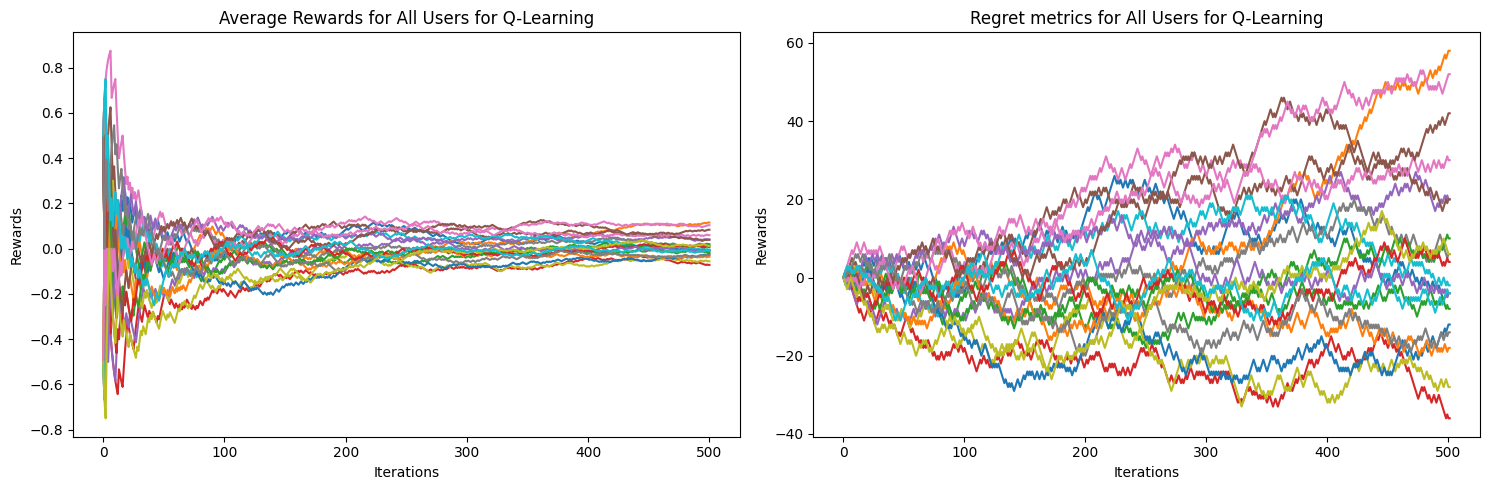

In [9]:
# Plot cumulative rewards for all users
# plt.figure(figsize=(10, 5))
# for i, cumulative_rewards in enumerate(all_cumulative_rewards):
#     plt.plot(cumulative_rewards, label=f'User {i+1}')
# plt.title('Cumulative Rewards for All Users')
# plt.xlabel('Iterations')
# plt.ylabel('Rewards')
# plt.legend()
# plt.show()

# Create a single figure with two subplots side by side
plt.figure(figsize=(15, 5))

# Plot average rewards for all users
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
for average_rewards in all_average_rewards:
    plt.plot(average_rewards)
plt.title('Average Rewards for All Users for Q-Learning')
plt.xlabel('Iterations')
plt.ylabel('Rewards')

# # Plot regrets for all users
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
for i, cumulative_rewards in enumerate(all_cumulative_rewards):
    plt.plot(cumulative_rewards, label=f'User {i+1}')
plt.title('Regret metrics for All Users for Q-Learning')
plt.xlabel('Iterations')
plt.ylabel('Rewards')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()
